In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import jcamp

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn import preprocessing

## What's in this notebook

### Load NIST gas IR spectra
### Load and fit DFT Vibrational frequencies and intensities
##### Unscaled vs. Scaled
##### Calculate 

* Pearson correlation


* Spearman correlation

##### Definition of Functions

In [2]:
fwhm0 = 2/np.pi
gamma0=fwhm0/2

def peak_y(intensity,frequency,x):
    sum_y = 0
    for i in range(number_peaks):
        y = intensity[i]
        fx = (1 / (gamma0*np.pi))  * (gamma0**2/((x-frequency[i])**2+gamma0**2))
        sum_y += y*fx
    return sum_y

In [2]:
#For broadened vibrational spectrum by Lorentz distribution with fwhm = 24
fwhm = 24
gamma=fwhm/2

def broad_y(intensity,frequency,x):
    sum_y = 0
    for i in range(number_peaks):
        y = intensity[i]
        fx = (1 / (gamma*np.pi))  * (gamma**2/((x-frequency[i])**2+gamma**2))
        sum_y += y*fx
    return sum_y

In [3]:
# For normalize spectrum with respect to the area under the curve and minmax scale to range 0 - 1
def scaler(x, y):
    area = np.trapz(y,x)
    y_normalized = y/area
    
    ymin = min(y_normalized)
    ymax = max(y_normalized)
    y_scaled = (y_normalized - ymin) / (ymax - ymin)
    
    return y_scaled  

In [4]:
# Fit to Lorentz distribution and scale intensity, and calculate correlation coefficient
def process(df,scaling_factor):
    frequency = df.frequencies
    scaled_frequency=df.frequencies*scaling_factor
    intensity = df.intensities
    
    y0 = broad_y(intensity,frequency,x)
    unscaled_y = scaler(x,y0)
    
    y1 = broad_y(intensity,scaled_frequency,x)
    scaled_y = scaler(x,y1)
    
    pcorr0, _ = pearsonr(IR_scaled_y,unscaled_y)
    print("Pearsons correlation of unscaled spectrum: %.3f" % pcorr0)
    scorr0, _ = spearmanr(IR_scaled_y,unscaled_y)
    print("Spearman correlation of unscaled spectrum: %.3f" % scorr0)
    
    pcorr1, _ = pearsonr(IR_scaled_y,scaled_y)
    print("Pearsons correlation of scaled spectrum: %.3f" % pcorr1)
    scorr1, _ = spearmanr(IR_scaled_y,scaled_y)
    print("Spearman correlation of scaled spectrum: %.3f" % scorr1)
    
    return unscaled_y, scaled_y

In [5]:
# Find scaling factor that resulted in maximal correlation coefficients
scale_t = np.arange(0.920, 1.000, 0.0010)
def optimize_scale(df):
    pcorr, scorr = list(),list()
    for t in scale_t:
        #print(t)
        scaled_frequency=df.frequencies*t
        intensity = df.intensities
        y1_tmp=broad_y(df.intensities,scaled_frequency,x)
        scaled_y = scaler(x,y1_tmp)
        pcorr1, _ = pearsonr(IR_scaled_y,scaled_y)
        scorr1, _ = spearmanr(IR_scaled_y,scaled_y)
        pcorr.append(pcorr1)
        scorr.append(scorr1)
        #print("Scaling factor: %.3f" % t, "Pearsons: %.3f" % pcorr1, "Spearman : %.3f" % scorr1)
    result = zip(scale_t,pcorr,scorr)
    zipped_result = list(result)
    df_result = pd.DataFrame(zipped_result,columns=['scaling factor','Pearson','Spearman'])
    print(df_result[df_result['Pearson']==max(pcorr)].iloc[:,0:2])
    print(df_result[df_result['Spearman']==max(scorr)].iloc[:,[0,2]])

In [6]:
# Find fwhm that resulted in maximal correlation coefficients
fwhm_f = np.arange(4, 200, 2)

def optimize_fwhm(df,scaling_t):
    pcorr, scorr = list(),list()
    for f in fwhm_f:
        #print(f)
        gammaf=f/2
        scaled_frequency=df.frequencies*scaling_t
        y1_tmp = 0
        for i in range(number_peaks):
            y = df.intensities[i]
            fx = (1 / (gammaf*np.pi))  * (gammaf**2/((x-scaled_frequency[i])**2+gammaf**2))
            y1_tmp += y*fx
        scaled_y = scaler(x,y1_tmp)
        pcorr1, _ = pearsonr(IR_scaled_y,scaled_y)
        scorr1, _ = spearmanr(IR_scaled_y,scaled_y)
        pcorr.append(pcorr1)
        scorr.append(scorr1)
        #print("fwhw: %.3f" % f, "Pearsons: %.3f" % pcorr1, "Spearman : %.3f" % scorr1)
    result = zip(fwhm_f,pcorr,scorr)
    zipped_result = list(result)
    df_result = pd.DataFrame(zipped_result,columns=['fwhm','Pearson','Spearman'])
    print(df_result[df_result['Pearson']==max(pcorr)].iloc[:,0:2])
    print(df_result[df_result['Spearman']==max(scorr)].iloc[:,[0,2]])

##### File path

In [15]:
compound = 'Amphetamine/'
path = "/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/Compounds_PubChem 3D/"

## Gas IR experimental spectrum from NIST

In [16]:
IR = jcamp.JCAMP_reader(path+compound+"Amphetamine_300-62-9-IR.jdx")
filename = "Amphetamine_300-62-9-IR"+" NIST Gas"

print("Range of wavenumber:")
print(IR['x'][0])
print(IR['x'][len(IR['x'])-1])

IR_scaled_y = scaler(IR['x'], IR['y'])
x = IR['x']

Range of wavenumber:
550.0
3846.0


Check Gas phase IR data plot

## Broadening IR spectrum with Lorentizan distribution

### Read DFT results
* Normal mode frequency in wavenumber
* IR intensities in KM/Mole
##### Four basis sets and scaling factor
* df1: 6-31G(d) (0.960)
* df2: 6-31+G(d,p) (0.964)
* df3: 6-31++G(d,p) (0.964)
* df4: 6-311++G(d,p) (0.964)

Scaling factors are obtained from CCCBDB databases. However, the exact combination of B3LYP/6-311++G(d,p) is not available in the CCCBDB database, the same scaling factor for B3LYP/6-31+G(d,p) is used.

In [17]:
output = "Amphetamine_0"

filename1 = path+compound+output+" unscaled DFT 631G(d) IR.csv"
#print(filename1)
df1 = pd.read_csv(filename1)
#print(df1.shape[0])

filename2 = path+compound+output+" unscaled DFT 631+G(d,p) IR.csv"
#print(filename2)
df2 = pd.read_csv(filename2)
#print(df2.shape[0])

filename3 = path+compound+output+" unscaled DFT 631++G(d,p) IR.csv"
#print(filename3)
df3 = pd.read_csv(filename3)
#print(df3.shape[0])

filename4 = path+compound+output+" unscaled DFT 6311++G(d,p) IR.csv"
print(filename4)
df4 = pd.read_csv(filename4)
print(df4.shape[0])

number_peaks = df1.shape[0]

/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/Compounds_PubChem 3D/Amphetamine/Amphetamine_0 unscaled DFT 6311++G(d,p) IR.csv
63


In [19]:
print("Use CCCBD Scaling factors")
#print(filename1)
unscaled_y1, scaled_y1 = process(df1,0.960)
print("*********")
#print(filename2)
unscaled_y2, scaled_y2 = process(df2,0.964)
print("*********")
#print(filename3)
unscaled_y3, scaled_y3 = process(df3,0.964)
print("*********")
#print(filename4)
unscaled_y4, scaled_y4 = process(df4,0.964)
print("*********")

Use CCCBD Scaling factors
Pearsons correlation of unscaled spectrum: 0.376
Spearman correlation of unscaled spectrum: 0.687
Pearsons correlation of scaled spectrum: 0.653
Spearman correlation of scaled spectrum: 0.825
*********
Pearsons correlation of unscaled spectrum: 0.518
Spearman correlation of unscaled spectrum: 0.756
Pearsons correlation of scaled spectrum: 0.754
Spearman correlation of scaled spectrum: 0.839
*********
Pearsons correlation of unscaled spectrum: 0.516
Spearman correlation of unscaled spectrum: 0.755
Pearsons correlation of scaled spectrum: 0.754
Spearman correlation of scaled spectrum: 0.839
*********
Pearsons correlation of unscaled spectrum: 0.570
Spearman correlation of unscaled spectrum: 0.772
Pearsons correlation of scaled spectrum: 0.794
Spearman correlation of scaled spectrum: 0.836
*********


In [21]:
#print(filename1)
optimize_scale(df1)
print("*********")
#print(filename2)
optimize_scale(df2)
print("*********")
#print(filename3)
optimize_scale(df3)
print("*********")
#print(filename4)
optimize_scale(df4)
print("*********")

    scaling factor   Pearson
37           0.957  0.662549
    scaling factor  Spearman
43           0.963  0.826741
*********
    scaling factor   Pearson
41           0.961  0.766073
    scaling factor  Spearman
52           0.972  0.843573
*********
    scaling factor   Pearson
41           0.961  0.766487
    scaling factor  Spearman
51           0.971  0.843558
*********
    scaling factor   Pearson
45           0.965  0.795435
    scaling factor  Spearman
55           0.975  0.844939
*********


In [23]:
#print(filename1)
optimize_fwhm(df1,0.960)
print("*********")
#print(filename2)
optimize_fwhm(df2,0.964)
print("*********")
#print(filename3)
optimize_fwhm(df3,0.964)
print("*********")
#print(filename4)
optimize_fwhm(df4,0.964)
print("*********")
#print(filename5)

    fwhm   Pearson
48   100  0.758283
    fwhm  Spearman
20    44  0.827432
*********
    fwhm   Pearson
36    76  0.865985
    fwhm  Spearman
32    68  0.848498
*********
    fwhm   Pearson
36    76  0.865678
    fwhm  Spearman
27    58    0.8484
*********
    fwhm   Pearson
32    68  0.879963
    fwhm  Spearman
32    68  0.847828
*********


### Superimpose of experimental and Theoretical spectra

Text(0, 0.5, 'IR Intensity')

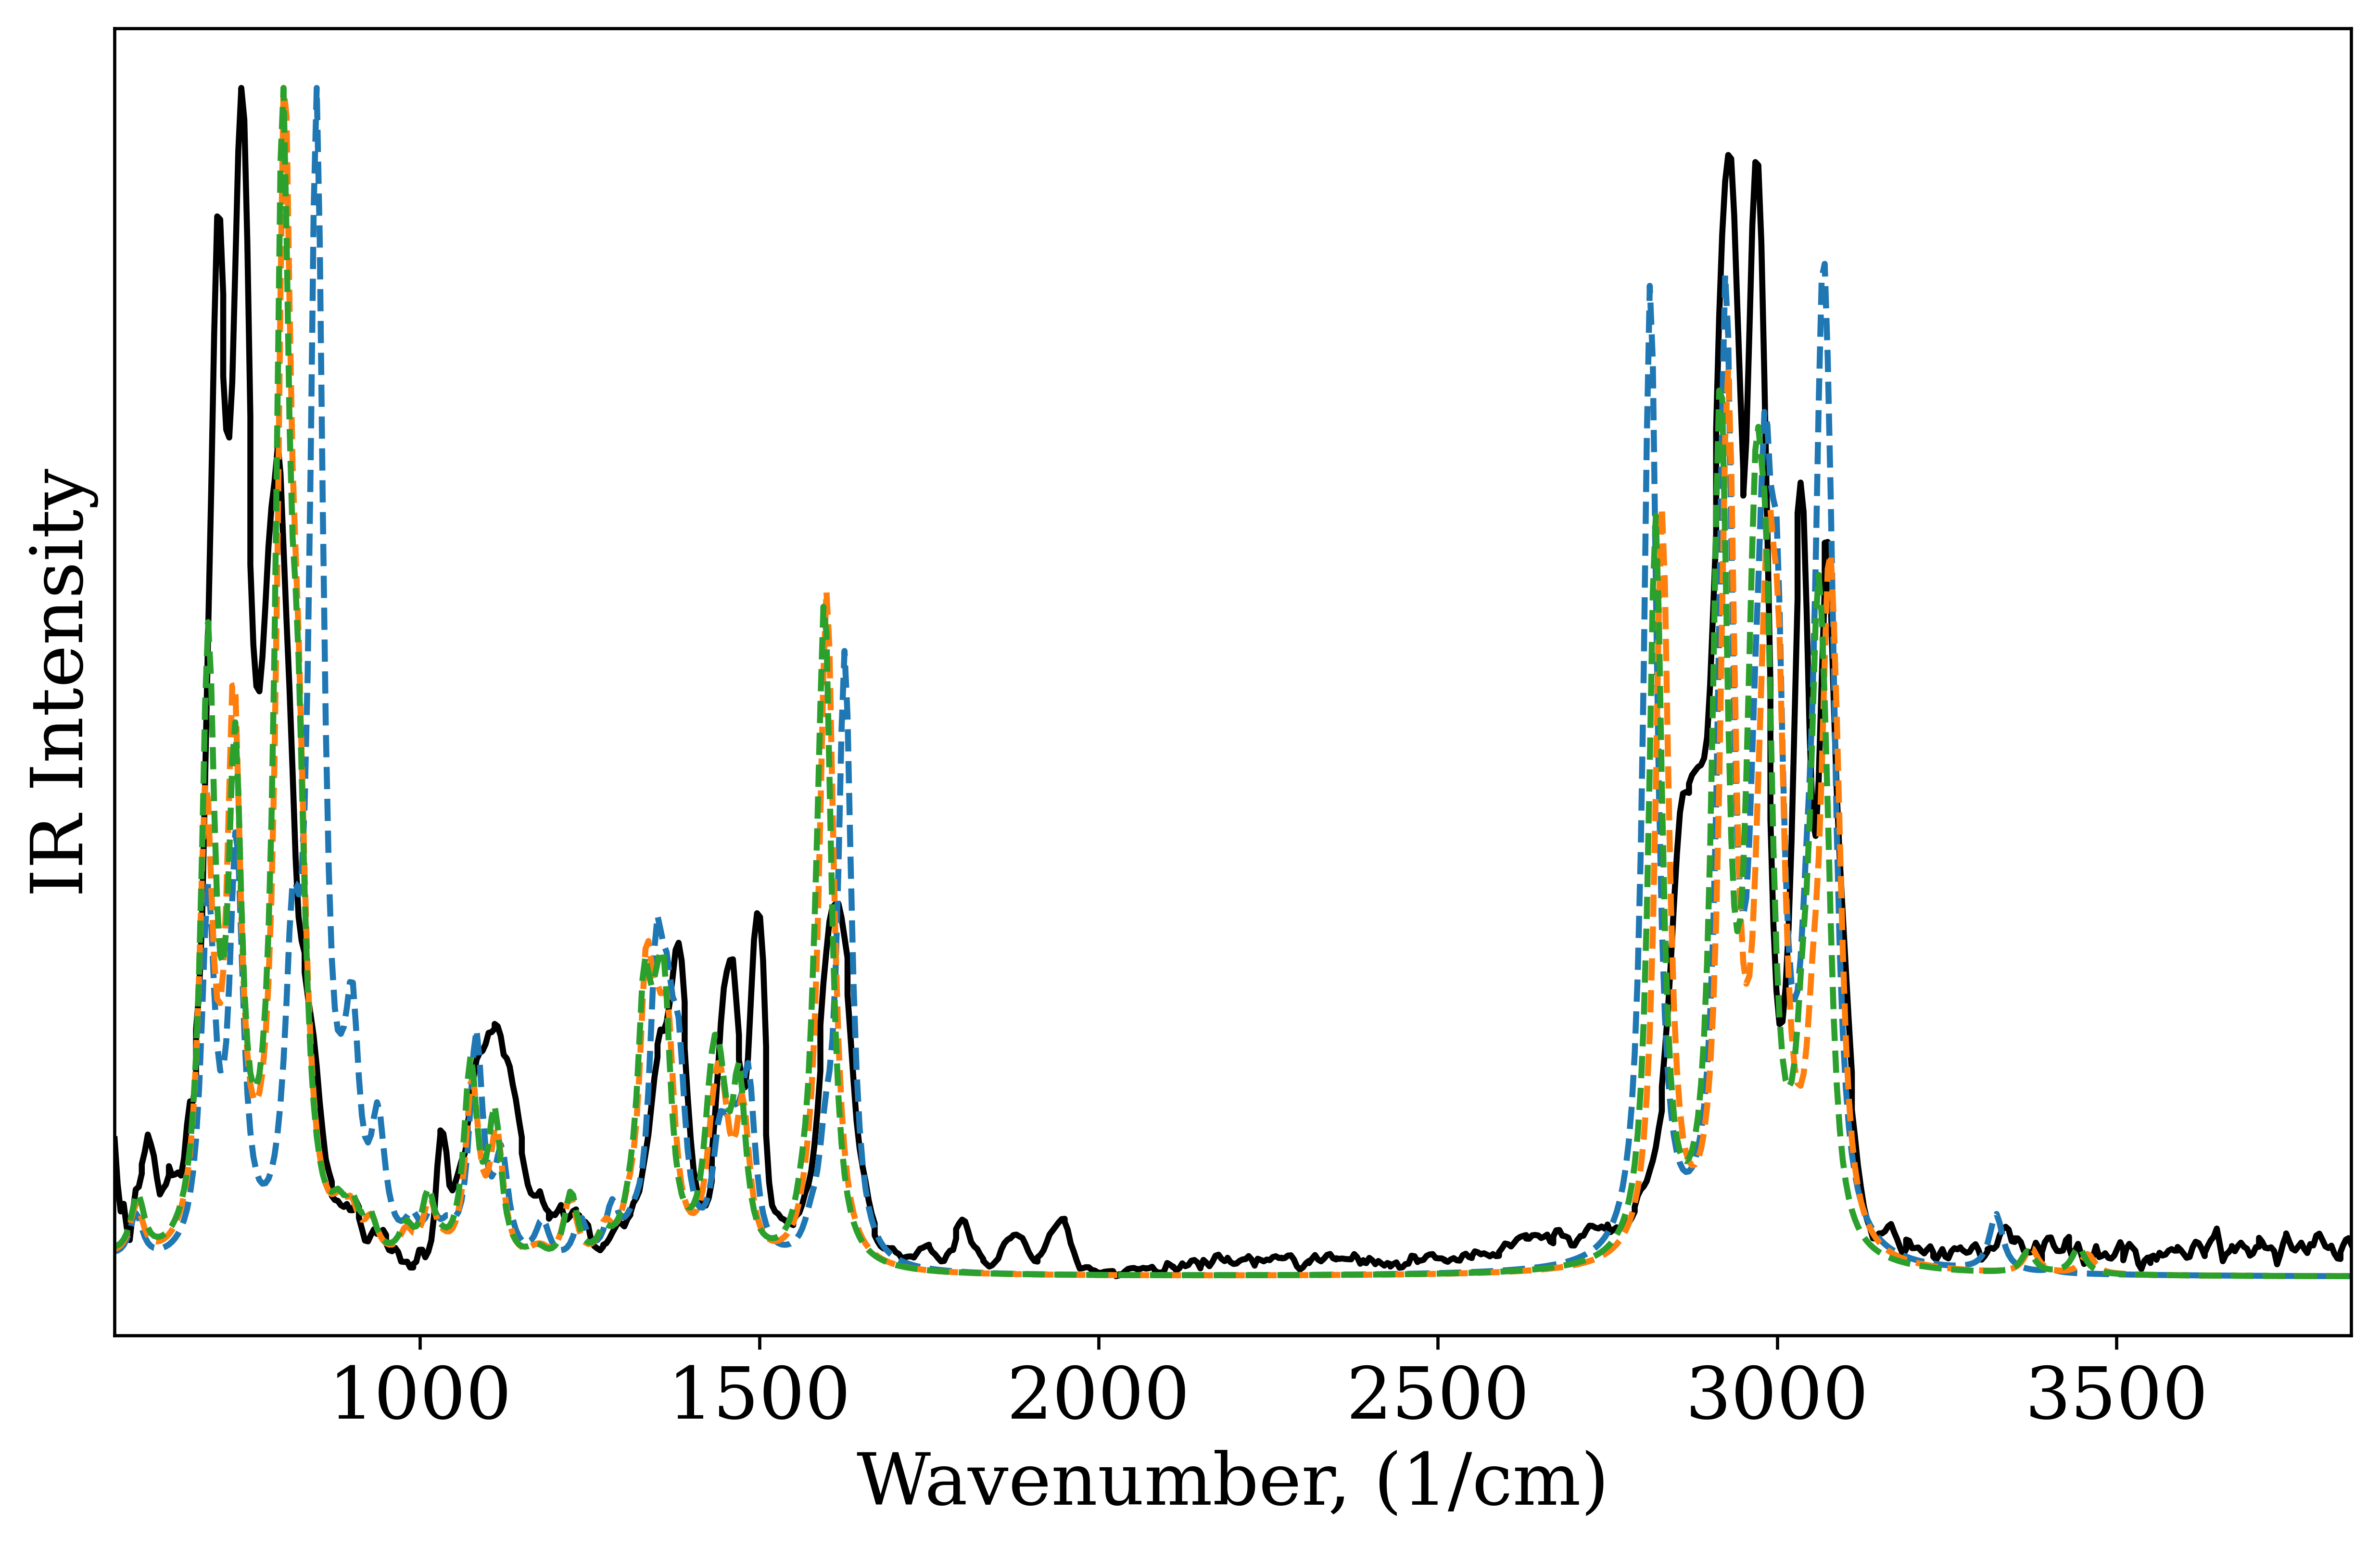

In [24]:
fig = plt.figure(figsize=(10, 6), dpi=600)
plt.rc('font', family='serif', size = 18)
plt.plot(x,IR_scaled_y,'k',label='Experimental Gas IR')
plt.plot(x,scaled_y1,"--",label='6-31G(d)')
#plt.plot(x,scaled_y2,"--",label='6-31+G(d,p)')
plt.plot(x,scaled_y3,"--",label='6-31++G(d,p)')
plt.plot(x,scaled_y4,"--",label='6-311++G(d,p)')
plt.xlim(550,3846)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,labelleft=False)
#plt.legend()
#legend = plt.legend(loc='upper center', shadow=True, fontsize=14)
plt.xlabel('Wavenumber, (1/cm)')
plt.ylabel('IR Intensity')
#fig.savefig(path+compound+output+" IR DFT spectra in comparison with the experimental spectrum.png", bbox_inches='tight')

## Superimpose DFT IR spectra of conformers

Five-lowest energy conformers

Calculate correlation coefficient with experimental spectrum

Basis: 6311++G(d,p)

Scaling factor = 0.964

In [25]:
# Fit to Lorentz distribution and scale intensity, and calculate correlation coefficient
def process_scaled(df,scaling_factor):
    frequency = df.frequencies*scaling_factor
    intensity = df.intensities
    
    y = broad_y(intensity,frequency,x)
    fit_y = scaler(x,y)
    
    pcorr, _ = pearsonr(IR_scaled_y,fit_y)
    print("Pearsons correlation of conformer vs experimental: %.3f" % pcorr)
    scorr, _ = spearmanr(IR_scaled_y,fit_y)
    print("Spearman correlation of conformer vs experimental: %.3f" % scorr)  
    return fit_y

In [26]:
conformers = "Amphetamine_"

In [27]:
filename_1 = path+compound+conformers+"1"+" unscaled DFT 6311++G(d,p) IR.csv"
df_1 = pd.read_csv(filename_1)
print(df_1.shape[0])

filename_2 = path+compound+conformers+"2"+" unscaled DFT 6311++G(d,p) IR.csv"
df_2 = pd.read_csv(filename_2)

filename_3 = path+compound+conformers+"3"+" unscaled DFT 6311++G(d,p) IR.csv"
df_3 = pd.read_csv(filename_3)

filename_4 = path+compound+conformers+"4"+" unscaled DFT 6311++G(d,p) IR.csv"
df_4 = pd.read_csv(filename_4)

63


In [28]:
conformer_0 = process_scaled(df4,0.964)
print("*********")
conformer_1 = process_scaled(df_1,0.964)
print("*********")
conformer_2 = process_scaled(df_2,0.964)
print("*********")
conformer_3 = process_scaled(df_3,0.964)
print("*********")
conformer_4 = process_scaled(df_4,0.964)

Pearsons correlation of conformer vs experimental: 0.794
Spearman correlation of conformer vs experimental: 0.836
*********
Pearsons correlation of conformer vs experimental: 0.674
Spearman correlation of conformer vs experimental: 0.829
*********
Pearsons correlation of conformer vs experimental: 0.793
Spearman correlation of conformer vs experimental: 0.837
*********
Pearsons correlation of conformer vs experimental: 0.742
Spearman correlation of conformer vs experimental: 0.830
*********
Pearsons correlation of conformer vs experimental: 0.718
Spearman correlation of conformer vs experimental: 0.821


In [261]:
optimize_scale(df4)
print("*********")
optimize_scale(df_1)
print("*********")
optimize_scale(df_2)
print("*********")
optimize_scale(df_3)
print("*********")
optimize_scale(df_4)

    scaling factor   Pearson
63           0.983  0.704306
    scaling factor  Spearman
54           0.974   0.88165
*********
    scaling factor   Pearson
46           0.966  0.715353
    scaling factor  Spearman
53           0.973   0.89356
*********
    scaling factor   Pearson
48           0.968  0.745451
    scaling factor  Spearman
53           0.973  0.881787
*********
    scaling factor   Pearson
50            0.97  0.808098
    scaling factor  Spearman
48           0.968  0.882406
*********
    scaling factor   Pearson
46           0.966  0.637548
    scaling factor  Spearman
55           0.975  0.887737


In [32]:
# Use the optimized scaling factor
conformer_1 = process_scaled(df_1,0.973)
conformer_2 = process_scaled(df_2,0.973)

Pearsons correlation of conformer vs experimental: 0.612
Spearman correlation of conformer vs experimental: 0.825
Pearsons correlation of conformer vs experimental: 0.808
Spearman correlation of conformer vs experimental: 0.848


Text(0, 0.5, 'IR Intensity')

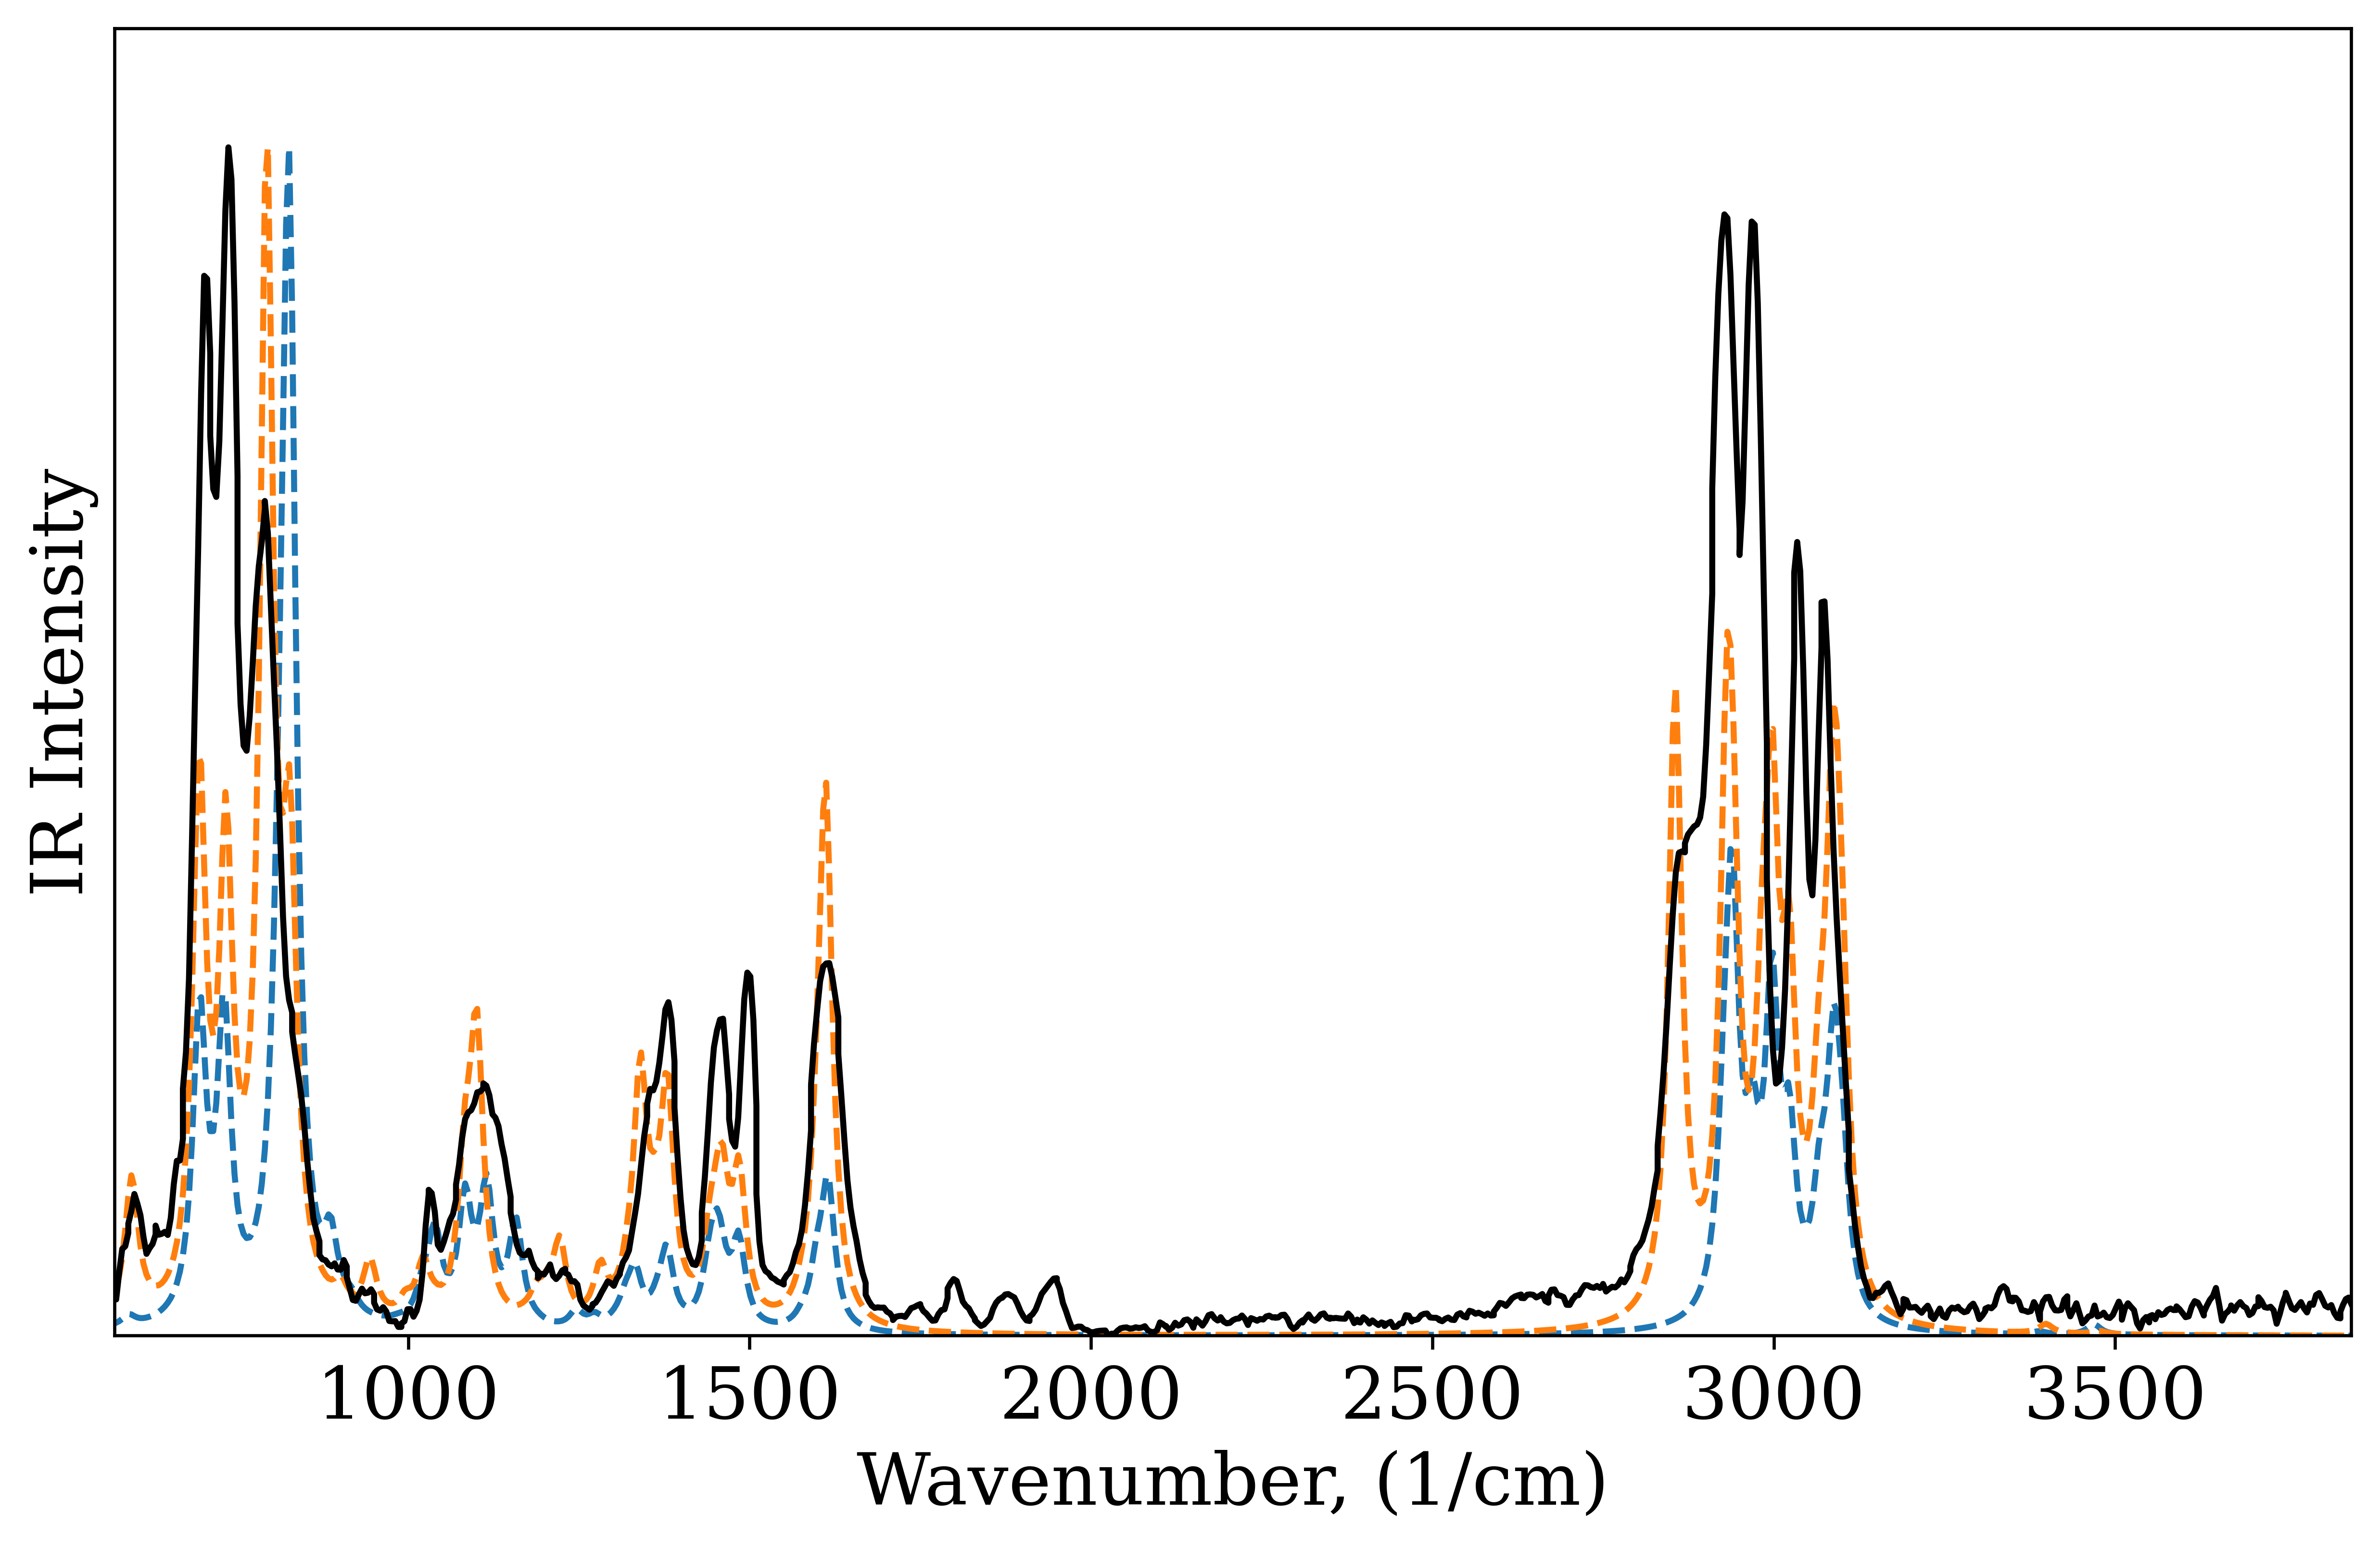

In [33]:
fig = plt.figure(figsize=(10, 6), dpi=600)
plt.rc('font', family='serif', size = 18)
#plt.plot(x,conformer_0,"--",label="Conformer_0")
plt.plot(x,conformer_1,"--",label="Conformer 1")
plt.plot(x,conformer_2,"--",label="Conformer 2")
plt.plot(x,IR_scaled_y,'k',label='Experimental Gas IR')
plt.ylim(0,1.1)
plt.xlim(570,3846)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,labelleft=False)
#plt.legend()
#legend = plt.legend(loc='upper right', shadow=True, fontsize=10)
plt.xlabel('Wavenumber, (1/cm)')
plt.ylabel('IR Intensity')
#fig.savefig(path+compound+conformers+"conformers IR DFT spectra in comparison with the experimental spectrum.png", bbox_inches='tight')

### IR spectra comparison

In [3]:
count = 400
x = []
for i in range(1801):
    #print(count)
    x.append(int(count))
    count += int(2)

In [4]:
path = "/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/Compounds_PubChem 3D/"
path_ML = '/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/ML results/'

In [32]:
THC = pd.read_csv(path+"THC/"+"THC 0.971 scaled DFT 6311++G(d,p) conformer weighted total IR.csv") 
Synhexyl = pd.read_csv(path+"Synhexyl/"+"Synhexyl 0.971 scaled DFT 6311++G(d,p) conformer weighted total IR.csv")
DMHP = pd.read_csv(path+"DMHP/"+"DMHP 0.971 scaled DFT 6311++G(d,p) conformer weighted total IR.csv")
CBN = pd.read_csv(path+"Cannabinol/"+"cannabinol 0.971 scaled DFT 6311++G(d,p) conformer weighted total IR.csv")

CBD = pd.read_csv(path+"Cannabidiol/"+"Cannabidiol 0.971 scaled DFT 6311++G(d,p) conformer weighted total IR.csv")

In [24]:
#MDA = pd.read_csv(path+"MDA/"+"MDA 0.971 scaled DFT 6311++G(d,p) conformer weighted total IR.csv")
#MDMA = pd.read_csv(path+"MDMA/"+"MDMA 0.971 scaled DFT 6311++G(d,p) conformer weighted total IR.csv")
#MBDB = pd.read_csv(path+"MBDB/"+"MBDB 0.971 scaled DFT 6311++G(d,p) conformer weighted total IR.csv")

#CT2 = pd.read_csv(path+"2C-T-2/"+"2C-T-2 0.971 scaled DFT 6311++G(d,p) conformer weighted total IR.csv")
#CB = pd.read_csv(path+"2C-B/"+"2C-B 0.971 scaled DFT 6311++G(d,p) conformer weighted total IR.csv")

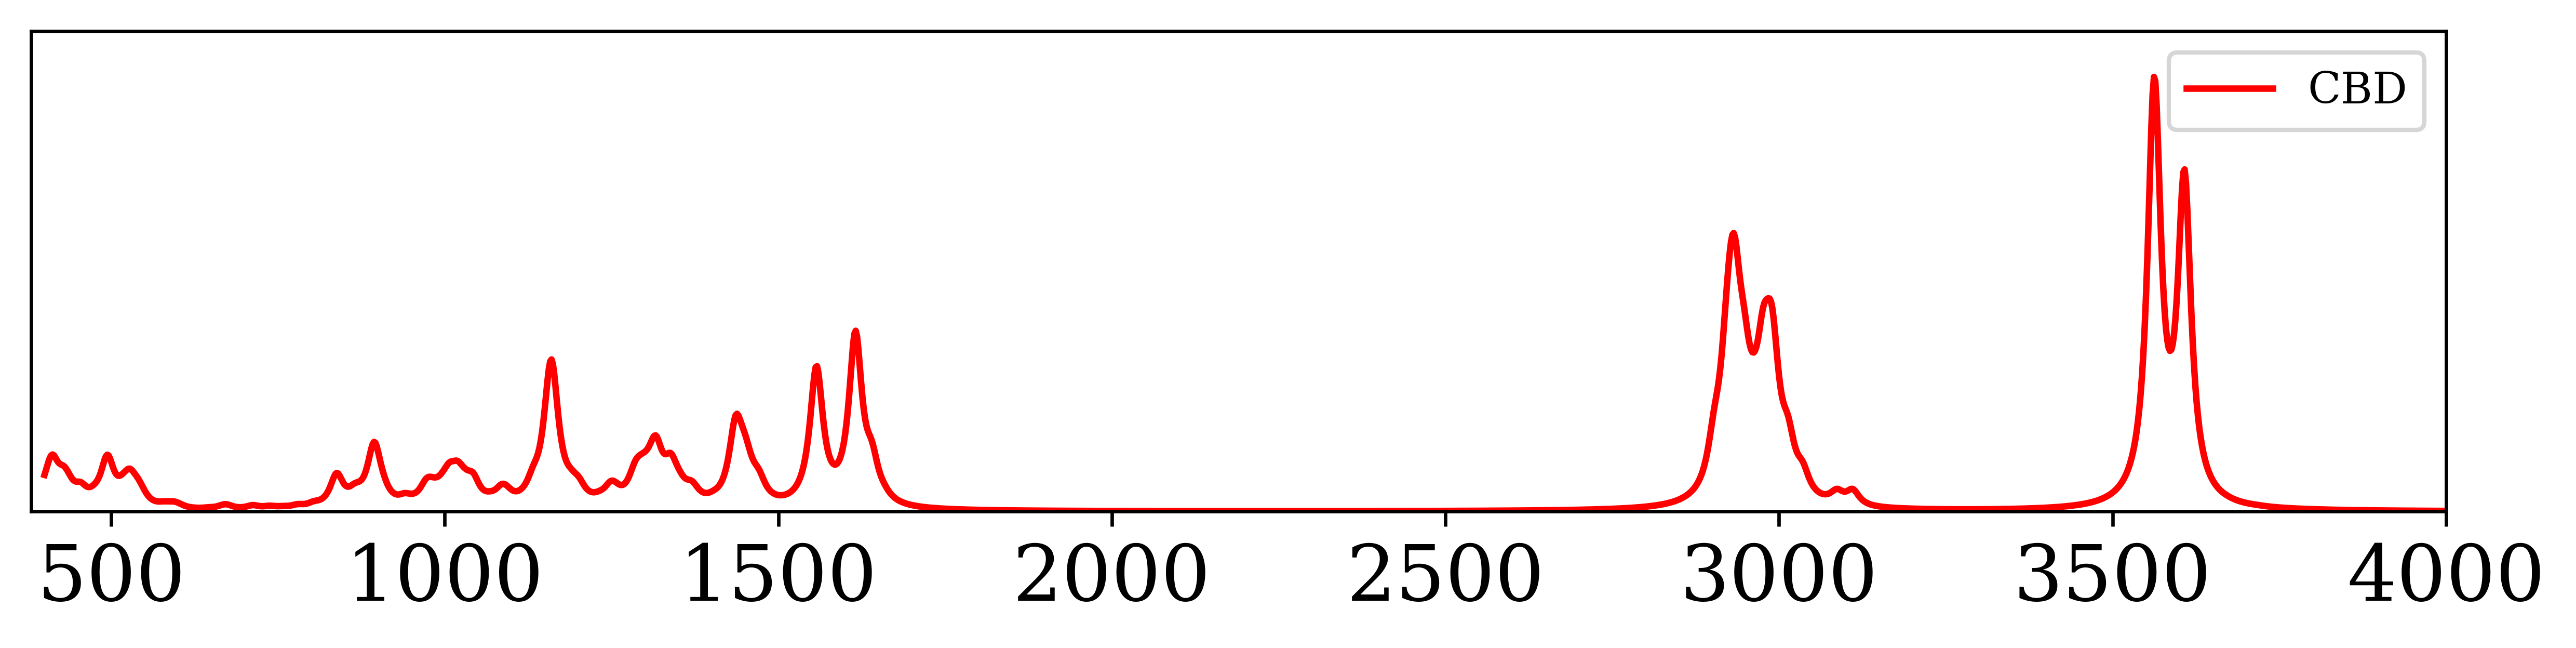

In [36]:
fig = plt.figure(figsize=(10, 2), dpi=600)
plt.rc('font', family='serif', size = 18)
#plt.plot(x,THC.IR,"k",label="THC")
#plt.plot(x,Synhexyl.IR,label="Synhexyl")
#plt.plot(x,DMHP.IR,label="DMHP")
#plt.plot(x,CBN.IR,label='CBN')

plt.plot(x,CBD.total_IR,'r',label='CBD')
plt.ylim(0,1.1)
plt.xlim(380,4000)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,labelleft=False)
    #bottom=False,labelbottom=False)
plt.legend()
legend = plt.legend(loc='upper right', shadow=False, fontsize=10)
#plt.xlabel('Wavenumber, (1/cm)')
#plt.ylabel('IR Intensity')
plt.show()
fig.savefig(path_ML+"Figure 5. CBD.png", bbox_inches='tight')